Analyze resident submitted move in work order description, identify common issues and patterns, prioritize urgent problems. No confidential info contained.

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import  matplotlib.pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from textblob import TextBlob
# from rake_nltk import Rake
from keybert import KeyBERT

c:\Users\Yijia Wang\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Pro_ALT_UP = pd.read_excel("UTD_2024_Propertyware_FS.xlsx", sheet_name="Updated_Pro")
Pro_ALT_UP = pd.DataFrame(Pro_ALT_UP)

In [3]:
Pro_ALT_UP["Description"] = Pro_ALT_UP["Description"].fillna('').astype(str)

### Step1: Prepare Text

In [4]:
des = Pro_ALT_UP['Description']

In [5]:
des = des.str.lower()

In [6]:
des = des.str.replace('[^\w\s]', '', regex=True) # remove punctuation

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Yijia Wang\AppData\Local\Temp\ipykernel_16660\865006759.py:1: SyntaxWarning: invalid escape sequence '\w'
  des = des.str.replace('[^\w\s]', '', regex=True) # remove punctuation


In [7]:
des = des.str.replace('\d+', '', regex=True) # remove numbers like 1. 2. ..

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Yijia Wang\AppData\Local\Temp\ipykernel_16660\953480354.py:1: SyntaxWarning: invalid escape sequence '\d'
  des = des.str.replace('\d+', '', regex=True) # remove numbers like 1. 2. ..


In [8]:
Pro_ALT_UP["Description"] = Pro_ALT_UP["Description"].fillna('').astype(str)

In [9]:
des_tokens = des.apply(lambda x: x.split()) # Tokenize

In [10]:
# nlp = spacy.load("en_core_web_sm")
# des_tokens = des.apply(lambda x: [token.text for token in nlp(x)])

In [11]:
irrelevant_words = {'need', 'one', 'working','work', 'issue', 'problem','fix', 'require','also','yes','please','coming','open'}
stop_words = ENGLISH_STOP_WORDS.union(irrelevant_words) # remove common stop words like "the", "is", "and"..
des_tokens = des_tokens.apply(lambda x: [word for word in x if word not in stop_words])

In [12]:
lemmatizer = WordNetLemmatizer() # get words back to root
des_tokens = des_tokens.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

### Step 2: Word Freq Analysis

In [13]:
all_words = [word for tokens in des_tokens for word in tokens]
word_freq = Counter(all_words)

In [14]:
top_words = word_freq.most_common(20)
for word, freq in top_words:
    print(f"{word}:{freq}")

water:316
door:276
bathroom:155
garage:124
kitchen:105
room:99
house:99
master:94
shower:89
doe:88
sink:81
toilet:77
leaking:75
leak:69
hot:69
light:64
need:64
floor:60
bedroom:59
dishwasher:57


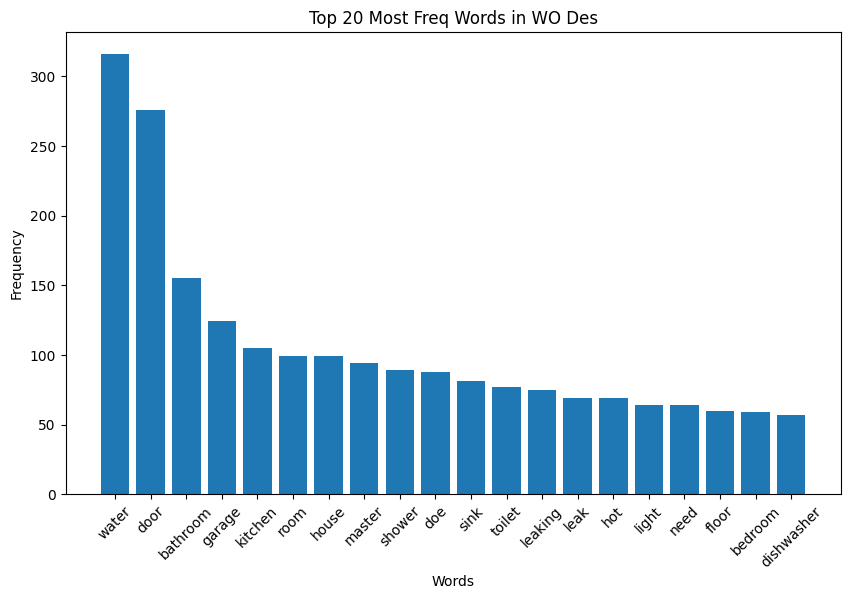

In [15]:
# Vis
words, freqs = zip(*top_words)
plt.figure(figsize=(10,6))
plt.bar(words, freqs)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Freq Words in WO Des')
plt.xticks(rotation=45)
plt.show()

### Step 3: Phrase Analysis (N-grams)

In [16]:
# Generate Bigrams
def generate_ngrams(tokenized_description, n=2):
    all_ngrams = []
    for tokens in tokenized_description:
        all_ngrams.extend(list(ngrams(tokens, n)))
    return all_ngrams

bigrams = generate_ngrams(des_tokens, n=2)

In [17]:
bigrams

[('noticed', 'alive'),
 ('alive', 'dead'),
 ('dead', 'cockroches'),
 ('cockroches', 'specially'),
 ('specially', 'kitchen'),
 ('kitchen', 'pic'),
 ('pic', 'attached'),
 ('attached', 'pest'),
 ('pest', 'treatment'),
 ('treatment', 'dishwasher'),
 ('dishwasher', 'properly'),
 ('properly', 'doe'),
 ('doe', 'wash'),
 ('wash', 'dry'),
 ('dry', 'dish'),
 ('dish', 'master'),
 ('master', 'bedroom'),
 ('bedroom', 'toilet'),
 ('toilet', 'pot'),
 ('pot', 'leaking'),
 ('leaking', 'flush'),
 ('flush', 'gap'),
 ('gap', 'flooring'),
 ('flooring', 'outside'),
 ('outside', 'main'),
 ('main', 'bedroom'),
 ('bedroom', 'kitchen'),
 ('kitchen', 'light'),
 ('light', 'blinking'),
 ('blinking', 'bad'),
 ('bad', 'electrician'),
 ('electrician', 'fixed'),
 ('fixed', 'socket'),
 ('socket', 'kitchen'),
 ('kitchen', 'attached'),
 ('attached', 'wall'),
 ('wall', 'properly'),
 ('properly', 'gap'),
 ('gap', 'door'),
 ('door', 'backyard'),
 ('backyard', 'doe'),
 ('doe', 'close'),
 ('close', 'gas'),
 ('gas', 'burner'),

In [18]:
trigrams = generate_ngrams(des_tokens, n=3)

In [19]:
bigrams_freq = Counter(bigrams)
trigrams_freq = Counter(trigrams)

In [20]:
# Show most common ones (Bi)
top_bigrams = bigrams_freq.most_common(10)
print("Top 10 Bigrams:")
for bigram, freq in top_bigrams:
    print(f"{bigram}:{freq}")

Top 10 Bigrams:
('garage', 'door'):47
('pte', 'pet'):43
('master', 'bathroom'):42
('hot', 'water'):38
('living', 'room'):27
('master', 'bedroom'):26
('laundry', 'room'):25
('pet', 'alarm'):25
('just', 'moved'):21
('water', 'damage'):18


In [21]:
# Show most common ones (tri)
top_trigrams = trigrams_freq.most_common(10)
print("Top 10 Trigrams:")
for trigram, freq in top_trigrams:
    print(f"{trigram}:{freq}")

Top 10 Trigrams:
('pte', 'pet', 'alarm'):22
('pte', 'pet', 'dog'):16
('garage', 'door', 'opener'):14
('pet', 'dog', 'alarm'):11
('left', 'garage', 'door'):6
('master', 'bedroom', 'toilet'):5
('door', 'doesnt', 'close'):5
('laundry', 'room', 'door'):5
('kitchen', 'pte', 'pet'):5
('sliding', 'glass', 'door'):4


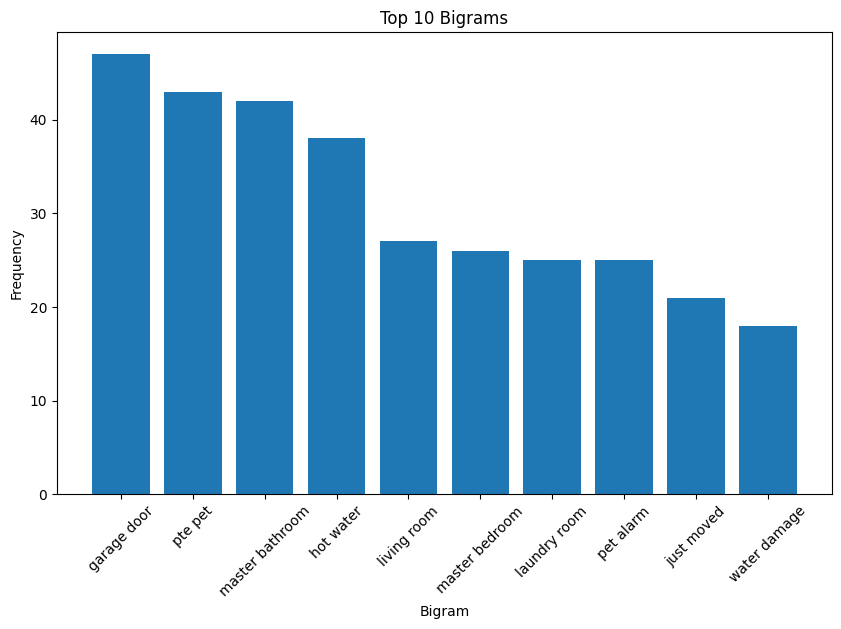

In [22]:
# Vis
bigram_words, bigram_counts = zip(*top_bigrams)
bigram_words = [' '.join(bigram) for bigram in bigram_words]

plt.figure(figsize=(10,6))
plt.bar(bigram_words, bigram_counts)
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.title('Top 10 Bigrams')
plt.xticks(rotation=45)
plt.show()

In [23]:
# I think things related with pet are not useful
pet_keywords = {'pet','dog','cat','pets','animal','puppy','kitten','pte','just','moved'}
def filter_ngrams(ngrams, pet_keywords):
    return [(ngram, freq) for ngram, freq in ngrams if not any(word in pet_keywords for word in ngram)]

filtered_bigrams = filter_ngrams(bigrams_freq.most_common(), pet_keywords)
filter_trigrams = filter_ngrams(trigrams_freq.most_common(), pet_keywords)

In [24]:
filtered_bigrams

[(('garage', 'door'), 47),
 (('master', 'bathroom'), 42),
 (('hot', 'water'), 38),
 (('living', 'room'), 27),
 (('master', 'bedroom'), 26),
 (('laundry', 'room'), 25),
 (('water', 'damage'), 18),
 (('ice', 'maker'), 18),
 (('kitchen', 'sink'), 17),
 (('water', 'heater'), 15),
 (('door', 'opener'), 14),
 (('door', 'doe'), 13),
 (('water', 'leaking'), 13),
 (('water', 'pressure'), 12),
 (('leaking', 'water'), 12),
 (('door', 'door'), 11),
 (('water', 'leak'), 11),
 (('cold', 'air'), 11),
 (('water', 'line'), 11),
 (('garbage', 'disposal'), 11),
 (('sink', 'leaking'), 10),
 (('shower', 'door'), 10),
 (('light', 'switch'), 10),
 (('water', 'ice'), 10),
 (('guest', 'bathroom'), 10),
 (('soon', 'possible'), 10),
 (('doe', 'close'), 9),
 (('close', 'properly'), 9),
 (('look', 'like'), 9),
 (('bathroom', 'toilet'), 9),
 (('doe', 'lock'), 9),
 (('dining', 'room'), 9),
 (('bathroom', 'sink'), 8),
 (('closet', 'door'), 8),
 (('bathroom', 'upstairs'), 8),
 (('upstairs', 'bathroom'), 8),
 (('doesnt

In [25]:
filter_trigrams

[(('garage', 'door', 'opener'), 14),
 (('left', 'garage', 'door'), 6),
 (('master', 'bedroom', 'toilet'), 5),
 (('door', 'doesnt', 'close'), 5),
 (('laundry', 'room', 'door'), 5),
 (('sliding', 'glass', 'door'), 4),
 (('water', 'line', 'ran'), 4),
 (('ice', 'maker', 'water'), 4),
 (('water', 'hot', 'water'), 4),
 (('garage', 'door', 'doe'), 4),
 (('master', 'bathroom', 'sink'), 4),
 (('water', 'doe', 'hot'), 4),
 (('properly', 'gap', 'door'), 3),
 (('right', 'garage', 'door'), 3),
 (('door', 'close', 'properly'), 3),
 (('door', 'opener', 'key'), 3),
 (('maker', 'water', 'line'), 3),
 (('hot', 'water', 'heater'), 3),
 (('house', 'hot', 'water'), 3),
 (('door', 'doe', 'lock'), 3),
 (('bathroom', 'hot', 'water'), 3),
 (('phone', 'number', 'issuepart'), 3),
 (('ga', 'united', 'state'), 3),
 (('doesnt', 'close', 'properly'), 3),
 (('master', 'closet', 'door'), 3),
 (('kitchen', 'sink', 'leaking'), 3),
 (('master', 'bathroom', 'shower'), 3),
 (('tub', 'master', 'bathroom'), 3),
 (('hot', 'wa

In [26]:
# Show most common ones (Bi)
# Without Pet
top_f_bigrams = filtered_bigrams[:10]
print("\nTop 10 Filtered Bigrams:")
for bigram, freq in top_f_bigrams:
    print(f"{bigram}:{freq}")


Top 10 Filtered Bigrams:
('garage', 'door'):47
('master', 'bathroom'):42
('hot', 'water'):38
('living', 'room'):27
('master', 'bedroom'):26
('laundry', 'room'):25
('water', 'damage'):18
('ice', 'maker'):18
('kitchen', 'sink'):17
('water', 'heater'):15


In [27]:
# Show most common ones (Bi)
top_f_trigrams = filter_trigrams[:10]
print("\nTop 10 Filtered Trigrams:")
for trigram, freq in top_f_trigrams:
    print(f"{trigram}:{freq}")


Top 10 Filtered Trigrams:
('garage', 'door', 'opener'):14
('left', 'garage', 'door'):6
('master', 'bedroom', 'toilet'):5
('door', 'doesnt', 'close'):5
('laundry', 'room', 'door'):5
('sliding', 'glass', 'door'):4
('water', 'line', 'ran'):4
('ice', 'maker', 'water'):4
('water', 'hot', 'water'):4
('garage', 'door', 'doe'):4


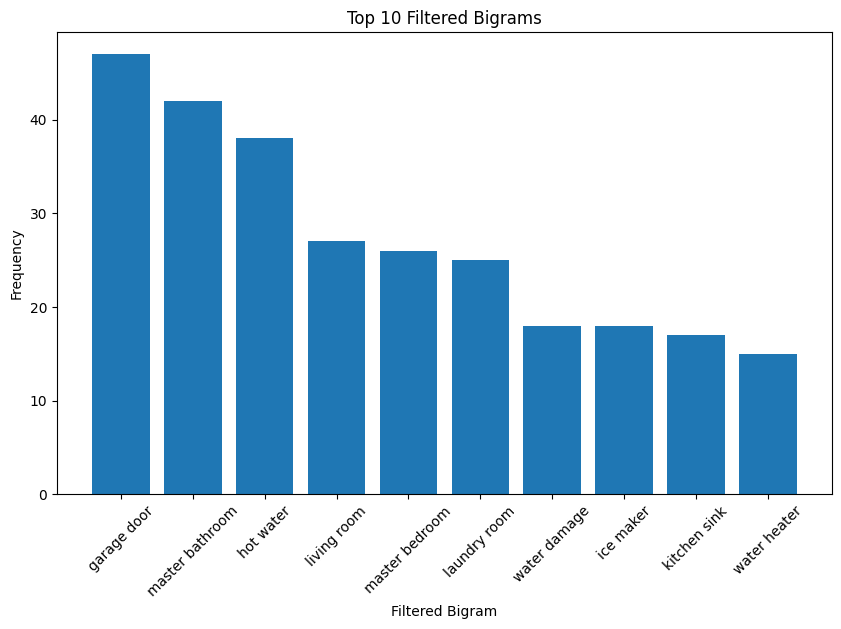

In [28]:
# Vis
f_bigram_words, f_bigram_counts = zip(*top_f_bigrams)
f_bigram_words = [' '.join(bigram) for bigram in f_bigram_words]

plt.figure(figsize=(10,6))
plt.bar(f_bigram_words, f_bigram_counts)
plt.xlabel('Filtered Bigram')
plt.ylabel('Frequency')
plt.title('Top 10 Filtered Bigrams')
plt.xticks(rotation=45)
plt.show()

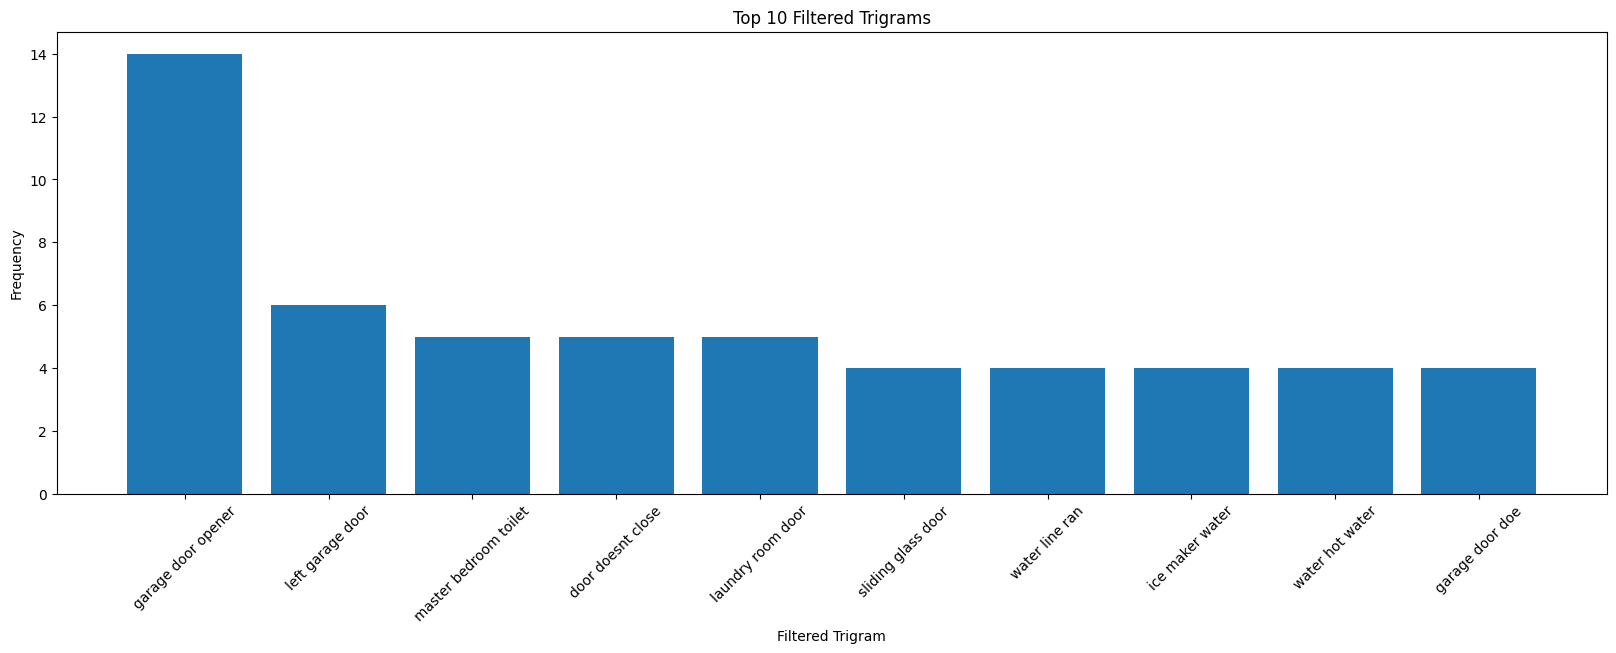

In [29]:
# Vis
f_trigram_words, f_trigram_counts = zip(*top_f_trigrams)
f_trigram_words = [' '.join(trigram) for trigram in f_trigram_words]

plt.figure(figsize=(20,6))
plt.bar(f_trigram_words, f_trigram_counts)
plt.xlabel('Filtered Trigram')
plt.ylabel('Frequency')
plt.title('Top 10 Filtered Trigrams')
plt.xticks(rotation=45)
plt.show()

### Step 4: Topic Modeling

Group words often shown together into one group

In [30]:
print(stop_words)

frozenset({'before', 'amongst', 'anyway', 'it', 'us', 'me', 'he', 'anywhere', 'besides', 'none', 'keep', 'ourselves', 'more', 'in', 'hundred', 'behind', 'but', 'you', 'still', 'nor', 'fifty', 'nothing', 'seemed', 'yes', 'seem', 'with', 'while', 'we', 'is', 'him', 'whose', 'con', 'bill', 'anyhow', 'all', 'give', 'among', 'amoungst', 'there', 'enough', 'see', 'less', 'very', 'always', 'most', 'found', 'serious', 'move', 'becomes', 'well', 'whenever', 'etc', 'need', 'un', 'their', 'yet', 'whoever', 'wherever', 'hereupon', 'what', 'beyond', 'further', 'noone', 'neither', 'himself', 'perhaps', 'next', 'everything', 'eleven', 'can', 'herein', 'whither', 'against', 'inc', 'someone', 'between', 'work', 'whether', 'again', 'until', 'part', 'nowhere', 'elsewhere', 'five', 'this', 'would', 'ten', 'de', 'although', 'on', 'sincere', 'forty', 'seeming', 'several', 'cant', 'off', 'yourself', 'hers', 'by', 'two', 'three', 'thereafter', 'whereas', 'into', 'nevertheless', 'above', 'call', 'might', 'also

In [31]:
cleaned_des = des_tokens.apply(lambda x: ' '.join(x))
# default_stop = ENGLISH_STOP_WORDS
# custom_stop = {'need', 'one', 'working','work', 'issue', 'problem','fix', 'require','pte','pet'}
# c_stop_words = default_stop.union(custom_stop)

vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words = 'english')
doc_term_matrix = vectorizer.fit_transform(cleaned_des)

In [32]:
Pro_ALT_UP['Description']

0      1. We have noticed alive and dead cockroches s...
1      1. We have noticed alive and dead cockroches s...
2      1.We are having to reset water heater for one ...
3      Part and Issue :  called to report that the to...
4                                         Floor flooding
                             ...                        
465    showerhead doesnt adjust downward properly. It...
466    There has been big roaches and baby ones seen ...
467    The outlets in the master bathroom do not work...
468    Location: Basement and the First guest bedroom...
469     Master bedroom ceiling fan is no longer working.
Name: Description, Length: 470, dtype: object

In [33]:
# Apply LDA
num_topic = 3
lda_model = LatentDirichletAllocation(n_components=num_topic, random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=3, random_state=42)

In [34]:
feature_names = vectorizer.get_feature_names_out()

# Define function to display topics
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))
        
display_topics(lda_model, feature_names, n_top_words=10) # display top 10 words for each topic

Topic 1:
door garage lock doe wall need hole close tub window
Topic 2:
water bathroom shower toilet leaking master sink leak door kitchen
Topic 3:
door water house ac ice refrigerator garage room light unit


In [35]:
# Assign topics to des
topic_assign = lda_model.transform(doc_term_matrix)

Pro_ALT_UP["Assigned Topic"] = topic_assign.argmax(axis=1) +1
print(Pro_ALT_UP[['Description','Assigned Topic']].head())

                                         Description  Assigned Topic
0  1. We have noticed alive and dead cockroches s...               2
1  1. We have noticed alive and dead cockroches s...               2
2  1.We are having to reset water heater for one ...               1
3  Part and Issue :  called to report that the to...               2
4                                     Floor flooding               2


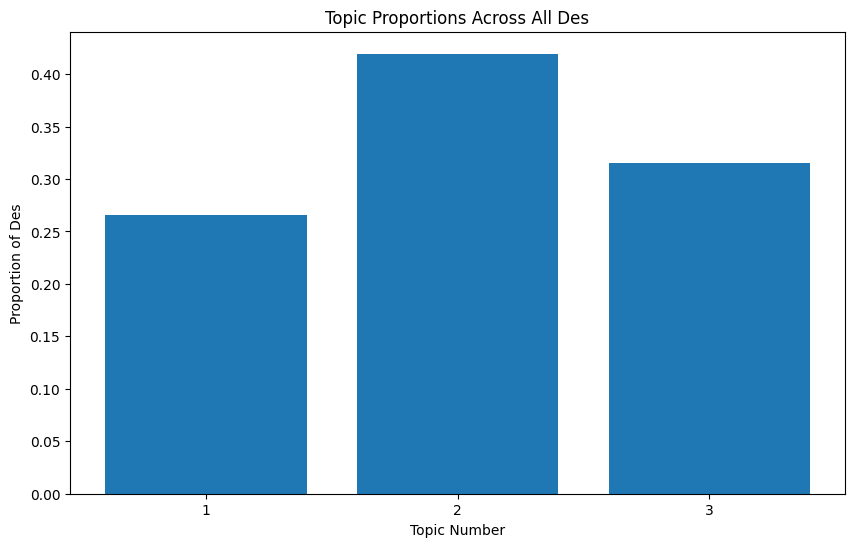

In [36]:
topic_prop = lda_model.transform(doc_term_matrix).mean(axis=0)
plt.figure(figsize=(10,6))
plt.bar(range(1, num_topic+1), topic_prop)
plt.xlabel('Topic Number')
plt.ylabel('Proportion of Des')
plt.title('Topic Proportions Across All Des')
plt.xticks(range(1, num_topic+1))
plt.show()

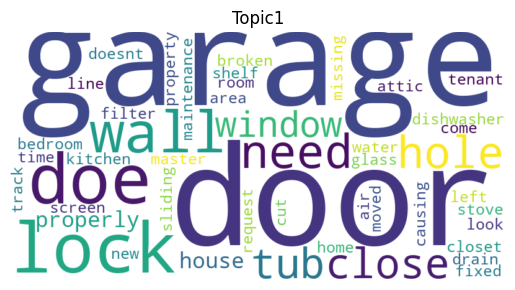

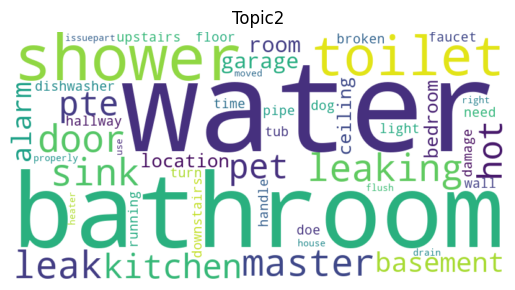

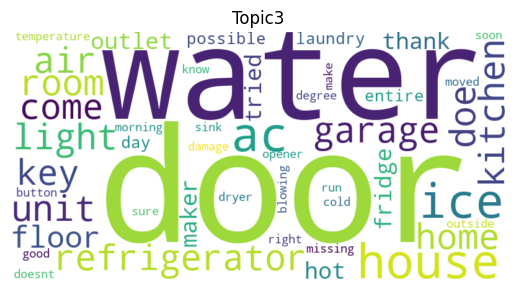

In [37]:
# create wordcloud for topic
for topic_idx, topic in enumerate(lda_model.components_):
    topic_words = ' '.join([feature_names[i] for i in topic.argsort()[:-50-1:-1]])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic{topic_idx + 1}")
    plt.show()

### Step 5: Clustering Similar Issues

In [38]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cleaned_des)

In [39]:
num_cluster = 5
kmeans = KMeans(n_clusters=num_cluster, random_state=42)
kmeans.fit(tfidf_matrix)
cluster_labels = kmeans.labels_

In [40]:
Pro_ALT_UP['Cluster'] = cluster_labels

In [41]:
# See des for each cluster
for cluster in range(num_cluster):
    print(f"\nCluster {cluster}:")
    print(Pro_ALT_UP[Pro_ALT_UP['Cluster'] ==  cluster]['Description'].head(10).values)


Cluster 0:
['1. We have noticed alive and dead cockroches specially in kitchen. Pics attached. We might need a pest treatment.\n2. Dishwasher is not working properly, it does not wash and dry the dishes.\n3. Master bedroom toilet pot is leaking when one flushes it.\n4. There are some gaps in flooring outside main bedroom\n5. Kitchen lights are blinking, hence can go bad, we need electrician to get that fixed.\n6. The socket on kitchen is not attached to wall properly and there is some gap\n7. The door in backyard does not close.\n8. One of the gas burner has missing component'
 '1. We have noticed alive and dead cockroches specially in kitchen. Pics attached. We might need a pest treatment.\n2. Dishwasher is not working properly, it does not wash and dry the dishes.\n3. Master bedroom toilet pot is leaking when one flushes it.\n4. There are some gaps in flooring outside main bedroom\n5. Kitchen lights are blinking, hence can go bad, we need electrician to get that fixed.\n6. The socke

In [42]:
# top words in each cluster
for cluster in range(num_cluster):
    cluster_des = cleaned_des[Pro_ALT_UP['Cluster'] == cluster]
    cluster_words = " ".join(cluster_des).split()
    print(f"\nCluster {cluster} Common Words:")
    print(Counter(cluster_words).most_common(10))


Cluster 0 Common Words:
[('door', 66), ('doe', 64), ('master', 47), ('shower', 34), ('bathroom', 34), ('toilet', 33), ('water', 33), ('properly', 30), ('lock', 30), ('bedroom', 29)]

Cluster 1 Common Words:
[('door', 173), ('garage', 93), ('room', 53), ('house', 48), ('water', 47), ('kitchen', 35), ('wall', 29), ('bathroom', 28), ('home', 28), ('key', 27)]

Cluster 2 Common Words:
[('ice', 35), ('water', 29), ('refrigerator', 27), ('door', 15), ('maker', 15), ('light', 15), ('fridge', 11), ('broken', 11), ('freezer', 10), ('house', 9)]

Cluster 3 Common Words:
[('ac', 42), ('air', 24), ('unit', 18), ('house', 12), ('degree', 10), ('pte', 8), ('pet', 8), ('alarm', 8), ('thermostat', 8), ('upstairs', 8)]

Cluster 4 Common Words:
[('water', 203), ('bathroom', 86), ('hot', 56), ('sink', 49), ('leaking', 42), ('shower', 41), ('kitchen', 37), ('leak', 36), ('toilet', 30), ('floor', 28)]


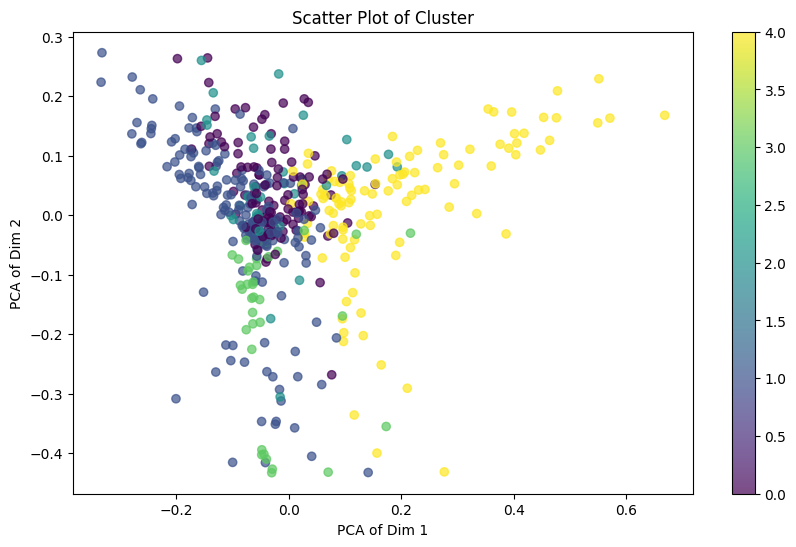

In [43]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(10,6))
plt.scatter(reduced_data[:,0], reduced_data[:, 1], c=cluster_labels, alpha=0.7)
plt.colorbar()
plt.title('Scatter Plot of Cluster')
plt.xlabel("PCA of Dim 1")
plt.ylabel("PCA of Dim 2")
plt.show()

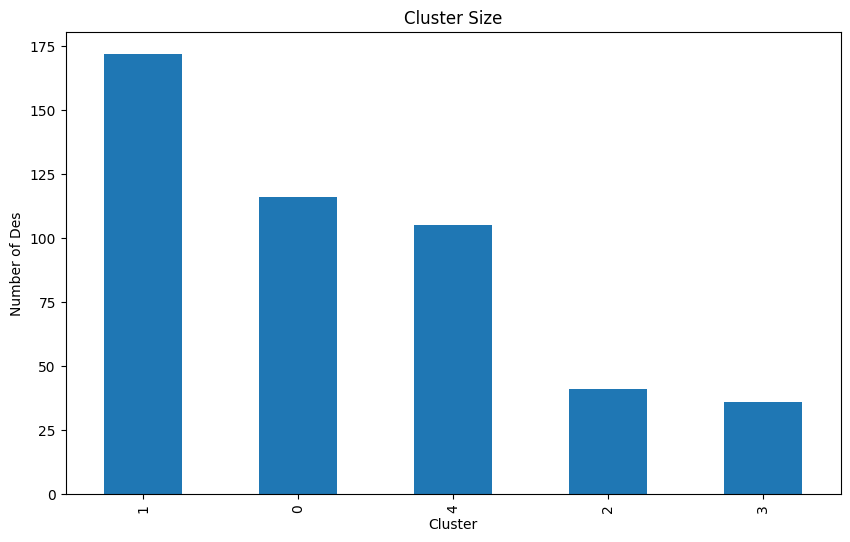

In [44]:
cluster_size = Pro_ALT_UP['Cluster'].value_counts()
cluster_size.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Size")
plt.xlabel("Cluster")
plt.ylabel("Number of Des")
plt.show()

### Step 6: Emotional Study

In [45]:
def get_sen(description):
    analysis = TextBlob(description)
    return analysis.sentiment.polarity

Pro_ALT_UP['Sentiment'] = cleaned_des.apply(get_sen)

In [46]:
negative_issues = Pro_ALT_UP[Pro_ALT_UP['Sentiment'] < 0]
print("Top Negative Issues:")
print(negative_issues[['Description', 'Sentiment']].sort_values(by='Sentiment').head(10))

Top Negative Issues:
                                           Description  Sentiment
29   The fan exhaust over the stove does not work. ...      -1.00
194  Contact #:  678-933-5216\nAddress: 2487 Woodfo...      -1.00
184  The dishwasher is not draining it holds water ...      -0.70
123  Theres leakage coming from water heater. I had...      -0.60
343  Air conditioner is cutting off before reaching...      -0.60
373  They just moved in \n\nThe upstairs AC for 4 b...      -0.60
294  3978 Cutler Donahoe Way\n\nAC is frozen and no...      -0.60
164      The house is cold. The heater is not working.      -0.60
206  There is a leak underneath the sink when washi...      -0.50
19   Blinds on all 3 bedroom windows improperly ins...      -0.43


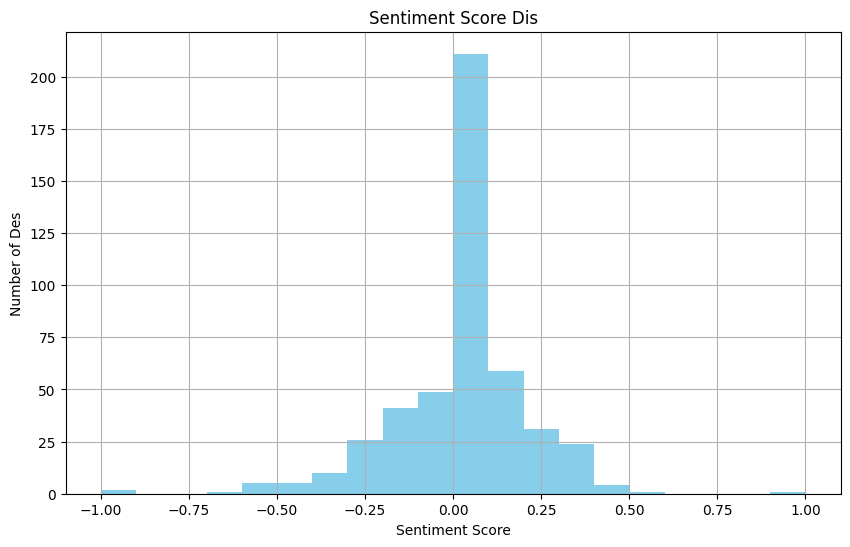

In [47]:
# Vis
plt.figure(figsize=(10,6))
Pro_ALT_UP['Sentiment'].hist(bins=20, color='skyblue')
plt.title('Sentiment Score Dis')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Des')
plt.show()

In [48]:
# Add flag based on negative sentiment
Pro_ALT_UP['Priority'] = Pro_ALT_UP['Sentiment'].apply(lambda x: 'High' if x < -0.5 else('Medium' if x < 0 else 'Low'))
high_priority = Pro_ALT_UP[Pro_ALT_UP['Priority'] == 'High']
print(high_priority[['Description','Sentiment','Priority']])

                                           Description  Sentiment Priority
29   The fan exhaust over the stove does not work. ...       -1.0     High
123  Theres leakage coming from water heater. I had...       -0.6     High
164      The house is cold. The heater is not working.       -0.6     High
184  The dishwasher is not draining it holds water ...       -0.7     High
194  Contact #:  678-933-5216\nAddress: 2487 Woodfo...       -1.0     High
294  3978 Cutler Donahoe Way\n\nAC is frozen and no...       -0.6     High
343  Air conditioner is cutting off before reaching...       -0.6     High
373  They just moved in \n\nThe upstairs AC for 4 b...       -0.6     High


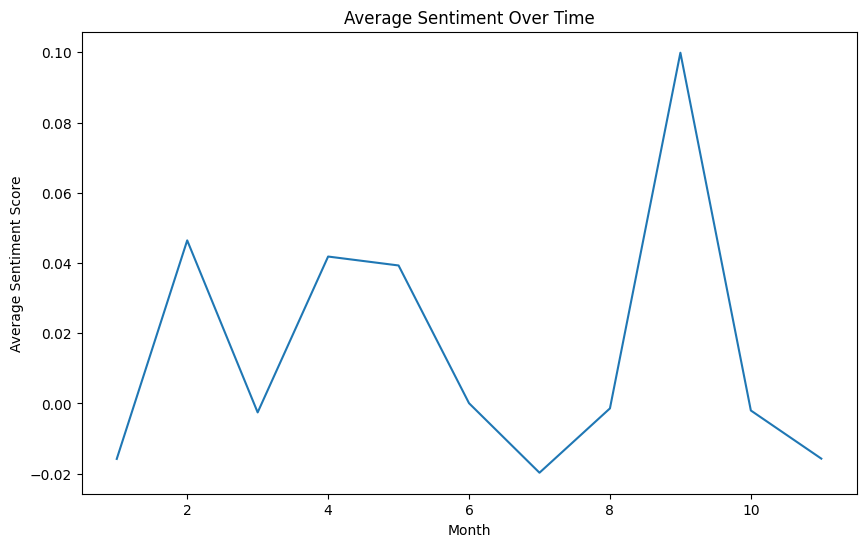

In [49]:
Pro_ALT_UP['Month'] = pd.to_datetime(Pro_ALT_UP['Date Created']).dt.month # get months out
monthly_sent = Pro_ALT_UP.groupby('Month')['Sentiment'].mean()
monthly_sent.plot(kind='line', figsize=(10,6))
plt.title('Average Sentiment Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.show()

### Step 7: Key Words for Each

In [ ]:
kw_model = KeyBERT()
def extract_kw_keybert(description):
    keywords = kw_model.extract_keywords(des, top_n=5)
    return [kw[0] for kw in keywords]

Pro_ALT_UP['KeyBERT'] = cleaned_des.apply(lambda x: extract_kw_keybert(x))
print(Pro_ALT_UP[['Description', 'KeyBERT']].head())